# Table of contents:

### Preliminary steps:
#### • Import necessary packages.
#### • Initialize values.
#### • Create aptitude and population functions.
#### • Create growth functions.
***
### Steps:
#### $\rightarrow$ Initialize matrices.
#### $\rightarrow$ Calculate the average (mean) rho in time t.
#### $\rightarrow$ Calculate the beliefs.
#### $\rightarrow$ Create expected payoff functions.
#### $\rightarrow$ Make training decisions.
#### $\rightarrow$ Match agents.
#### $\rightarrow$ Plot results on a diagram.

# Start of code.

Import the necessary packages / modules:

In [48]:
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FixedLocator, FixedFormatter
from statsmodels.tsa.holtwinters import ExponentialSmoothing as expsmooth

Set font style and size:

In [49]:
# mathtext
mpl.rcParams['mathtext.fontset'] = 'stix'
# other font
tnr = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 18}
mpl.rc('font', **tnr)

***
### Initialize payoff values, rho_s and rho_a, and the equilibrium intervals.

The cell below assigns numerical values to the payoffs which define $\rho^{S}$, $\rho^{A}$, and thus define the equilibrium intervals. <br><br>
The payoffs can be ranked as such: $\pi_{1} > \pi_{2} > \pi_{5} > \pi_{3} > \pi_{6} > \pi_{4}$.<br><br>
I chose these values arbitrarily – the analysis in Section 5 of my paper holds, without loss of generality. Because the payoffs are ordinal, the numerical values do not matter so long as the ranking of the payoffs is consistent with the assumptions in Section 3 of my paper. The specific numerical values can be changed in order to yield different equilibrium intervals.

In [50]:
# INITIALIZING PAYOFFS, RHO-S, RHO-A, AND INTERVALS

# defining payoffs
pi1 = 6
pi2 = 5
pi3 = 3
pi4 = 2.4
pi5 = 3.3
pi6 = 2.5

payoffs = [pi1, pi2, pi3, pi4, pi5, pi6]

# defining rhos, rhoa, and intervals
rhos = (pi5-pi3)/(pi2+pi5-pi3-pi4)
rhoa = (pi2-pi4)/(pi2+pi1-pi5-pi4)

interval_a = [rhoa, 1-rhoa]
interval_s = [rhos, 1-rhos]

### Create functions to generate aptitude and create population.

<b> def aptitude(rho) </b> accepts a value of rho_m or rho_f and returns a 0 or 1 to represent aptitude. rho_m, a value between 0 and 1, represents the proportion of the male population with an aptitude for wagework. The function returns a 0 for homework and 1 for wagework. rho_m determines the probability of returning a 1. (analogous for rho_f)<br><br>
<b> def population(n, rho) </b> accepts a value n and a value rho_m or rho_f. n is the number of agents of the male or female population that the function will return, and the rho_m / rho_f value will be passed in to aptitude( ) to assign an aptitude to the agent. population( ) returns a list of n integers, where the integer in the nth index represent the aptitude of the nth agent.

In [51]:
# CREATING BASIC POPULATION FUNCTIONS

# returns aptitude
def aptitude(rho):
    # 0 - homework
    # 1 - wagework
    apt = np.random.binomial(1, rho, 1)
    return int(apt)

# generates population and assigns aptitude
def population(n, rho):
    poplist = []
    for i in range(n):
        poplist.append(aptitude(rho))
    return poplist

### Create growth function.
<b> def growth(x, growthrate, init_rho, totalgens) </b> is a function that changes the input rho such that it tends toward 0.5. The function accepts 4 input paramaters: x, which is the current time period k; growthrate, which is the growth rate assigned to $\rho$; init_rho, which is the initial value of $\rho$ set for the male or female population; and totalgens, which is the total number of periods for which the simulation lasts, represented in the paper as t. <br><br>
If the initial value of $\rho$ (denoted init_rho in the function's inputs) is greater than 0.5, the function decays and tends toward 0.5. If init_rho is less than 0.5, the function grows and tends toward 0.5. <br>
This function works best if the simulation lasts for 50 periods, ie. if t = 50.

In [52]:
def growth(x, growthrate, init_rho, totalgens):
    
    # x is the current time period.
        # in the matrix functions below, I count down from the last period.
        # abs(totalgens-x) will give the current period.
    
    current = abs(totalgens-x)
    
    # if init_rho < 0.5, then it will be an increasing function
    # if init_rho > 0.5 then it will be a decreasing function
    a = (0.5/init_rho)-1
        
    return 0.5 / (1 + a*np.exp(-abs(growthrate)*current))

<br><br>
***
## Steps:

### Initialize matrices.
#### Create population of size n for k generations.
The two recursive functions below create a matrix for the male and female population, respectively. <br>
The matrix is of size (t x n+1) where t is the total number of generations and n is the size of the population. The extra column is the true value of $\rho$ in each generation.

\begin{bmatrix}
    agent_{t=0}^{n=1} &agent_{t=0}^{n=2} &\dots &agent_{t=0}^{n=n} &\rho_{true,\:t=0} \\
    agent_{t=1}^{n=1} &agent_{t=1}^{n=2} &\dots &agent_{t=1}^{n=n} &\rho_{true,\:t=1} \\
    \vdots &\vdots &\dots &\vdots &\vdots \\
    agent_{t=t}^{n=1} &agent_{t=t}^{n=2} &\dots &agent_{t=t}^{n=n} &\rho_{true,\:t=t} \\
\end{bmatrix}

In both the male and female cases, the growth rate of $\rho$ itself changes from generation to generation. The growth rate changes somewhere between 1% and 6% each period to simulate real GDP growth.<br>
After each period, the aptitude distribution for the next period is generated and appended to the population matrix.

In [53]:
def male_mat(n, rho, gens, growthrate, mat=None, init=None, totalgens=None):

    # n: number of agents
    # rho: initial rho
    # gens: total number of generations
    # growthrate: rate, expressed as decimal (eg. 0.03 for 3%)

    if mat is None:
        mat = [] # create empty list the first time around
    if init is None:
        init = rho # save initial rho value
    if totalgens is None:
        totalgens = gens # save the total generations
    
    if gens == 1:
        mat.append(population(n, rho) + [rho]) # final iteration, just append and return

    else:
        mat.append(population(n, rho) + [rho])
        
        # growthrate increases between 1% and 6% every period.
        growthrate = growthrate*(1+(random.randrange(1, 7)/100))
        # plug in t-1 rho, altered growthrate, and init
        rho = growth(gens, growthrate, init, totalgens)
        
        # recursion
        male_mat(n, rho, gens-1, growthrate, mat, init, totalgens)

    return mat


def female_mat(n, rho, gens, growthrate, mat=None, init=None, totalgens=None):

    # n: number of agents
    # rho: initial rho
    # gens: total number of generations
    # growthrate: rate, expressed as decimal (eg. 0.03 for 3%)

    if mat is None:
        mat = [] # create an empty list the first time around
    if init is None:
        init = rho # save the initial rho value
    if totalgens is None:
        totalgens = gens # save the total generations

    if gens == 1:
        mat.append(population(n, rho) + [rho]) # final iteration, just append and return

    else:
        mat.append(population(n, rho) + [rho])

        # growthrate increases between 1% and 6% every period.
        growthrate = growthrate*(1+(random.randrange(1, 7)/100))
        # plug in t-1 rho, altered growthrate, and init
        rho = growth(gens, growthrate, init, totalgens)
        
        # recursion
        female_mat(n, rho, gens-1, growthrate, mat, init, totalgens)

    return mat

The cell below creates test cases for male and female populations. These variables contain a matrix with t rows and n+1 columns. t = the total number of periods, n = the number of agents in the population. Column n+1 contains the true value of $\rho$ for that period.

In [54]:
# test cases

maletest = male_mat(50, 0.9, 50, -0.01)
femtest = female_mat(50, 0.1, 50, 0.02)

#### Create column headers and row indices.
For the column headers, I am using M1, M2, ..., Mn for male agents (same for females, but with F instead of M), and 'True rho' as the header for the value of $\rho_{true}$ in the last column of the row.
<br>
For row indices, I am using the integer k to denote the time period.

In [55]:
# create column headers

# MALE
Mcol_heads = []
for id in range(len(maletest[0])-1):
    Mcol_heads.append('M'+str(id+1))
Mcol_heads.append('True rho')


# FEMALE
Fcol_heads = []
for id in range(len(femtest[0])-1):
    Fcol_heads.append('F'+str(id+1))
Fcol_heads.append('True rho')

In [56]:
# create row indices

row_indices = []
for t in range(len(maletest)):
    row_indices.append(t)

#### Put the matrices into a dataframe.
I put my test matrices into Pandas DataFrame format. This makes the data easier to manipulate and see, and it allows me to use statsmodels functions on my values when generating $\rho_{belief}$.

In [57]:
# create dataframes

maledf = pd.DataFrame(maletest, columns=Mcol_heads, index=row_indices)
femdf = pd.DataFrame(femtest, columns=Fcol_heads, index=row_indices)

### Calculate the average (mean) $\rho$ in t = k.

#### Create a list containing the data.
In the cell below, I am calculating the mean $\rho$ based on the aptitudes in the population. This may or may not be equal to $\rho_{true}$. The average in row t=k will represent the mean aptitude for the population in t=k. <br>

In [58]:
# create avg rho columns

Mavg_rho = []
for i in range(len(maledf)):
    # calculate the mean aptitude
    avg = sum(maledf.iloc[i][:(maledf.shape[1]-1)]) / (maledf.shape[1]-1)
    # append to list
    Mavg_rho.append(avg)
    
Favg_rho = []
for i in range(len(femdf)):
    # calculate the mean aptitude
    avg = sum(femdf.iloc[i][:(femdf.shape[1]-1)]) / (femdf.shape[1]-1)
    # append to list
    Favg_rho.append(avg)

Add this data to the dataframe as a column, and label the header 'Avg. rho (t)'. 

In [59]:
# add the avg column to the df

maledf['Avg. rho (t)'] = Mavg_rho
femdf['Avg. rho (t)'] = Favg_rho

### Calculate the beliefs.

#### Create a belief function.
The belief function forms the agents' beliefs about $\rho$.<br> 
<b> def belief </b> accepts one input parameter, dataframe. Pass in the dataframe for which the believed $\rho$ is being calculated (*maledf* or *femdf*) <br><br>

This function also shifts (see *.shift( )*) the predictions down one period when appending them to the *maledf* / *femdf* dataframes. This means that the prediction in row t = k will represent the prediction made using the data in t = k-1 and earlier. <br>
The reason I have done this is because I am <b>assuming</b> that the aptitudes of the population in period t-1 become known in period t. Therefore the agents in time t can only form beliefs using information as recent as t-1, <b>not</b> information up to time t. <br><br>

*(Note: since I have shifted the predictions, the predicted $\rho$ in t = 0 is NaN. Thus when agents are making training decisions, I will assume that they train by aptitude in t = 0. This can be altered so that agents choose training randomly, train by sex, etc. ... Many options are available.)*

In [60]:
def belief(dataframe):
    
    # trend options for expsmooth()
        # 'add' = linear trend
        # 'mul' = exponential trend
    # i assume there is no trend when agents form beliefs
        
    # prepare data
    data = dataframe['Avg. rho (t)']
    # create class
    model = expsmooth(data, trend=None, damped_trend=False, seasonal=None, initialization_method='estimated').fit()
    
    # make prediction
    # shift the predictions down one period
    predicted = model.predict(start=data.index[0], end=data.index[-1]).shift()
    
    # bound the predictions such that they are in [0, 1]
    for i in range(len(predicted)):
        if predicted[i] < 0:
            predicted[i] = 0
        if predicted[i] > 1:
            predicted[i] = 1
    
    # return the predictions as a list
    return predicted.tolist()

#### Calculate the beliefs.
Create two variables, *M_bel* and *F_bel*. Call the belief function from the cell above and pass in the dataframe (*maledf* and *femdf*, respectively). Then add the prediction column to the correct dataframe, labelling the header "Belief of $\rho$". <br><br>

<b> Note: The values in *maledf* are the values that FEMALES use to make their decisions. *maledf* contains the belief of $\rho_{m}$. Males look to the "Belief of $\rho$" column in *femdf* to make decisions. </b>

In [61]:
# calculate the belief
M_bel = belief(maledf)
F_bel = belief(femdf)

# add belief to df
maledf['Belief of ' + str(r'$\rho$')] = M_bel
femdf['Belief of ' + str(r'$\rho$')] = F_bel

#### Graph true rho and believed rho.

Here I plot a line graph of the $\rho_{true}$ and $\rho_{belief}$ of one of the sexes over time to see how they differ.

In [145]:
def plot_true_v_belief(dataframe, eq_lines=None, neq_lines=None):
    
    # dataframe = maledf or femdf
    # eq_lines = where payoffs in true and believed states are equal. 
            # Default = None
            # type(eq_lines) = list
    # neq_lines = where payoffs in true and believed states are NOT equal.
            # Default = None
            # type(neq_lines) = list
    
    gen_num = [i for i in range(len(dataframe))]
    
    true_rho = dataframe['True rho']
    bel_rho = dataframe['Belief of ' + str(r'$\rho$')]
    
    fig = plt.figure(figsize=(20,10))
    
    # title - code based on dataframe
    gender_code = dataframe.columns[0][0]
    if gender_code == 'M': # if the agent ID starts with M (maledf)
        plt.title('Male '+str(r'$\rho^{true}$')+' and '+str(r'$\rho^{belief}$'), 
                     fontsize='x-large')
    if gender_code == 'F': # if the agent ID starts with F (femdf)
        plt.title('Female '+str(r'$\rho^{true}$')+' and '+str(r'$\rho^{belief}$'), 
                     fontsize='x-large')
    
    # set linecolors
    if gender_code == 'M': # if the agent ID starts with M (maledf)
        linecolour = 'darkblue'
    if gender_code == 'F': # if the agent ID starts with F (femdf)
        linecolour = 'orangered'
    

    # plot true and believed rho
    plt.plot(gen_num, true_rho, color=linecolour, linewidth=4)
    plt.plot(gen_num, bel_rho, color=linecolour, linestyle='dotted', linewidth=4)
    # set gridlines, labels, and legend
    plt.grid(linestyle='dotted')
    plt.xlabel('Period', fontsize='x-large')
    plt.ylabel(r'$\rho$', fontsize='x-large')
    plt.legend([r'$\rho^{true}$', r'$\rho^{belief}$'], fontsize='x-large')
    
    
    
    # PLOT EQ_LINES
    if eq_lines != None: # if I pass in a list for eq_lines
        for period in eq_lines:
            plt.axvline(x=period, color='palegreen', linewidth=2)
            
    # PLOT NEQ_LINES
    if neq_lines != None: # if I pass in a list for neq_lines
        for period in neq_lines:
            plt.axvline(x=period, color='lightpink', linewidth=2)
    
    
    plt.show()

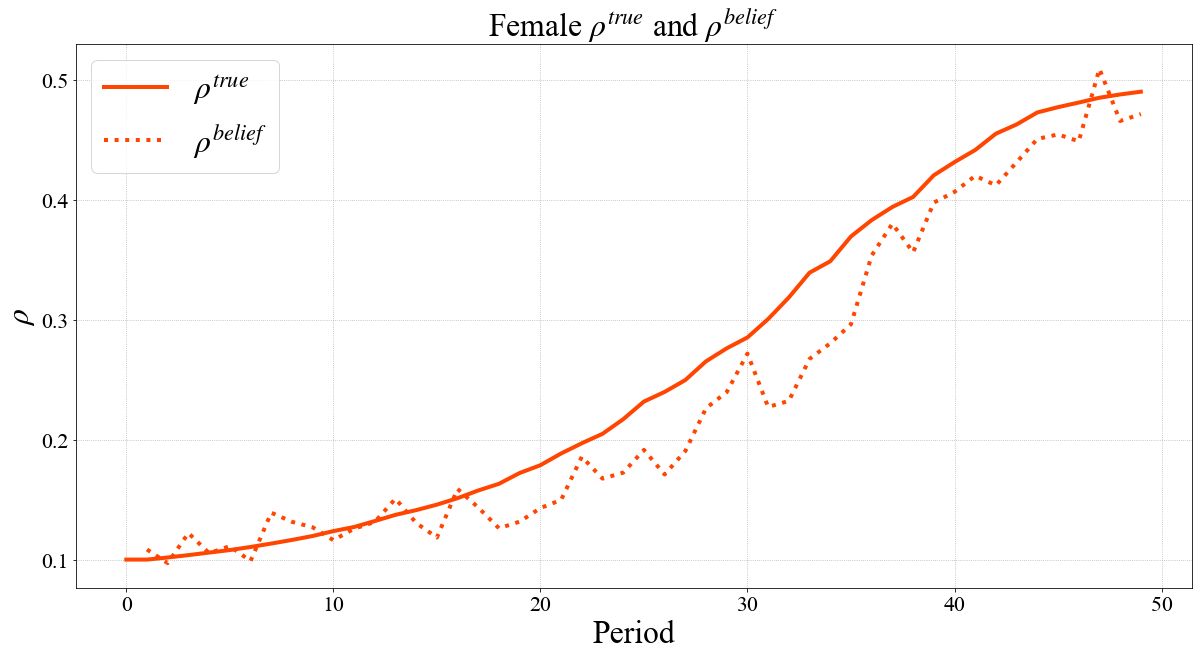

In [146]:
plot_true_v_belief(femdf)

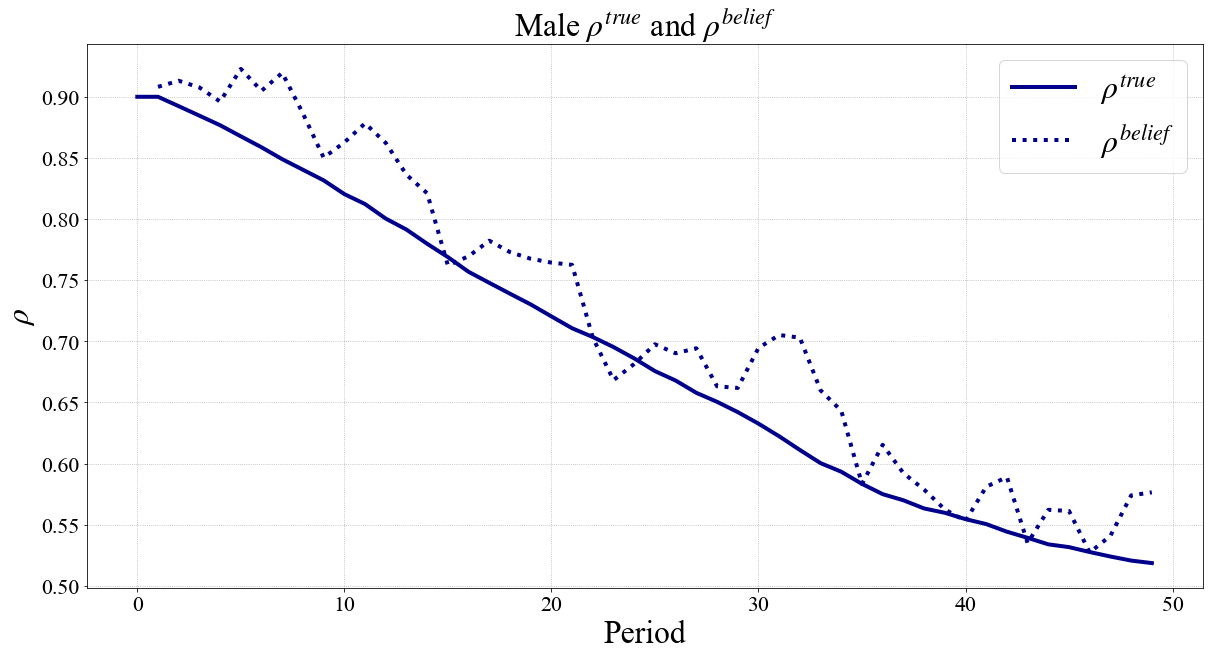

In [147]:
plot_true_v_belief(maledf)

#### Graph rho for both genders.

Here I plot a line graph of the $\rho_{true}$ and $\rho_{belief}$ of both sexes over time to see how they interact with one another.

In [137]:
def plot_rho(maledf=maledf, femdf=femdf, eq_lines=None, neq_lines=None):
    
    # eq_lines = where payoffs in true and believed states are equal. 
            # Default = None
            # type(eq_lines) = list
    # neq_lines = where payoffs in true and believed states are NOT equal.
            # Default = None
            # type(neq_lines) = list
    
    gen_num = [i for i in range(len(maledf))]
    
    # true and believed (MALE)
    true_m = maledf['True rho']
    bel_m = maledf['Belief of ' + str(r'$\rho$')]
    # true and believed (FEMALE)
    true_f = femdf['True rho']
    bel_f = femdf['Belief of ' + str(r'$\rho$')]
    
    fig = plt.figure(figsize=(25,12.5))
    
    # title
    plt.title('Male and Female '+str(r'$\rho$'), fontsize='xx-large')
    
    # plot male rho
    plt.plot(gen_num, true_m, color='darkblue', linewidth=4)
    plt.plot(gen_num, bel_m, color='darkblue', linestyle='dotted', linewidth=4)
    # plot female rho
    plt.plot(gen_num, true_f, color='orangered', linewidth=4)
    plt.plot(gen_num, bel_f, color='orangered', linestyle='dotted', linewidth=4)
    
    
    # set gridlines, labels, and legend
    plt.grid(linestyle='dotted')
    plt.xlabel('Period', fontsize='xx-large')
    plt.ylabel(r'$\rho$', fontsize='xx-large')
    plt.legend([r'$\rho_{m}^{true}$', r'$\rho_{m}^{belief}$', r'$\rho_{f}^{true}$',
                r'$\rho_{f}^{belief}$'], fontsize='large')
    
    
    
    # PLOT EQ_LINES
    if eq_lines != None: # if I pass in a list for eq_lines
        for period in eq_lines:
            plt.axvline(x=period, color='palegreen', linewidth=2)
            
    # PLOT NEQ_LINES
    if neq_lines != None: # if I pass in a list for neq_lines
        for period in neq_lines:
            plt.axvline(x=period, color='lightpink', linewidth=2)
    
    
    plt.show()

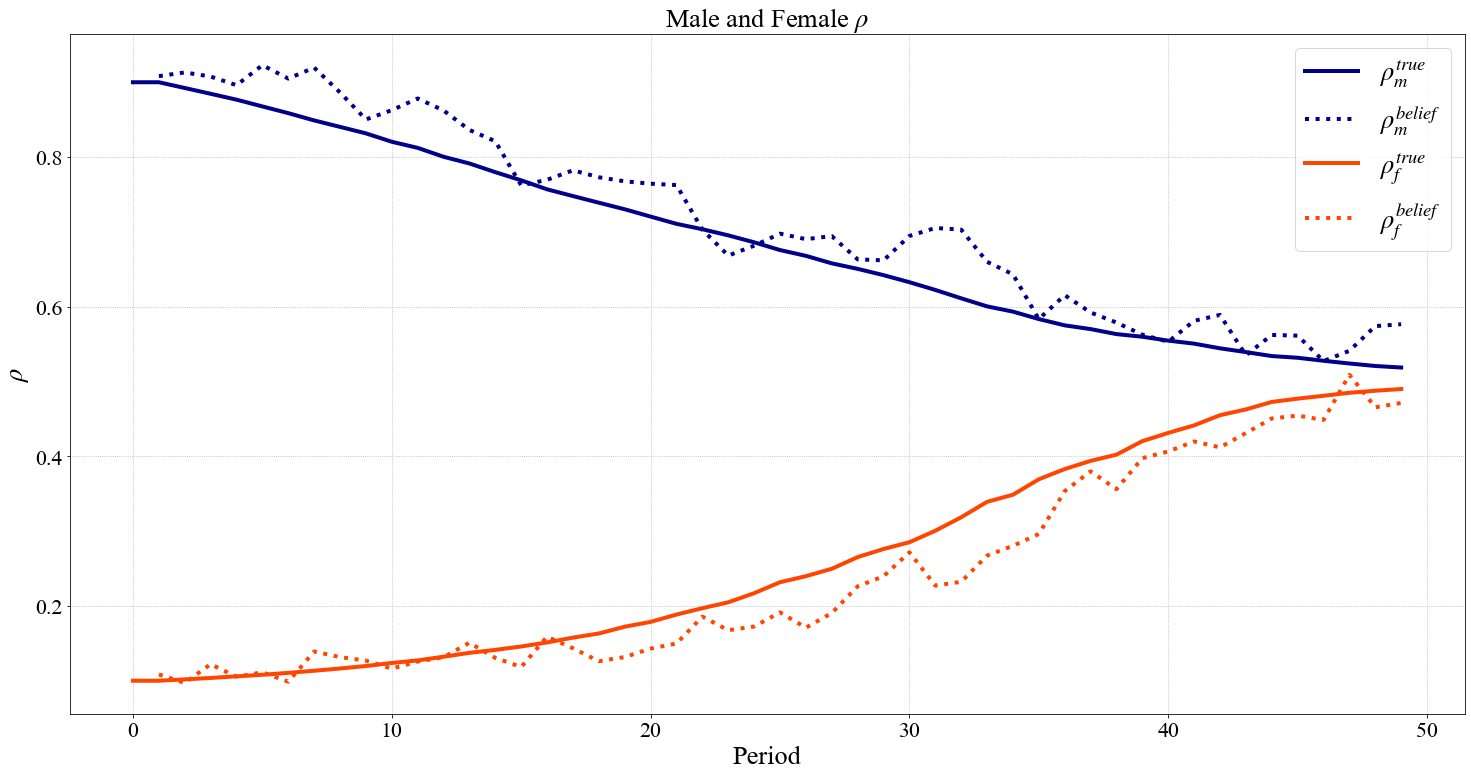

In [101]:
plot_rho()

### Create expected payoff functions.

When the agents make their training decisions, they calculate their expected payoffs in each scenario and choose $\tau$ that yields the highest expected payoff. <br> <br>

Originally, I was just going to use the decision rules that compared the opposite gender's rho to two constants, rho_a and rho_s. These two constants define the equilibrium regions: whether or not the opposite gender's rho (specifically, the *belief* thereof) was greater than rho_s or rho_a determined the training decision. <br>
The problem with this approach is that it means agents must either know or have a belief about what the opposite gender's training strategy is. <b>That is, as a representative female facing a training decision, do I think men will train by aptitude or by sex?</b> This is a complicated question and requires agents to deduce dominant training decisions of past generations, or flip a coin. Neither or these approaches are satisfying. <br>
> <u>Instead, I have opted to create a function that outputs one of four possible payoff matrices:</u><br><br>
<b>1. </b> I am female. <br>
<b> $\longrightarrow$ a) </b> I have an aptitude for homework. <br>
<b> $\longrightarrow$ b) </b> I have an aptitude for wagework. <br><br>
<b>2. </b> I am male. <br>
<b> $\longrightarrow$ a) </b> I have an aptitude for homework. <br>
<b> $\longrightarrow$ b) </b> I have an aptitude for wagework.<br><br>

Now, I can compare the payoffs within the matrix and select the strategy with the highest payoff. Whether the opposite gender trains by aptitude or by sex is beyond the agent's control: they will do what is in their best interest.<br><br>
*(Note: This references Lemmas 2 and 3 from Engineer & Welling (1999).)*

Below I have made the expected payoff function for males and females, respectively. I have split them into 2 cells, as they are both long functions.

In [102]:
def male_Epi(male_apt, rho_f, pis=payoffs):
    
    # initialize variables
    pi1 = pis[0]
    pi2 = pis[1]
    pi3 = pis[2]
    pi4 = pis[3]
    pi5 = pis[4]
    pi6 = pis[5]
    
    # First, funnel into the correct matrix.
    
    # Second, create the 2x3 matrix. 
        # The rows are the male's training decisions (h or w).
        # The columns are the potential female's training decisions (h, w, or apt).
        # Calculate 6 expected values:
            # E_hh: tau(m) = h. tau(f) = h. 
            # E_wh: tau(m) = h. tau(f) = w. 
            # E_ah: tau(m) = h. tau(f) = alpha(f). 
            # E_hw: tau(m) = w. tau(f) = h. 
            # E_ww: tau(m) = w. tau(f) = w. 
            # E_aw: tau(m) = w. tau(f) = alpha(f). 
    
    # Third, return that matrix.
    
    
    if male_apt == 0: # alpha(m) = h
        
        # row 0: tau(m) = h
        E_hh = rho_f*pi5 + (1-rho_f)*pi4
        E_wh = rho_f*pi1 + (1-rho_f)*pi2
        E_ah = rho_f*pi1 + (1-rho_f)*pi4
        
        # row 1: tau(m) = w
        E_hw = rho_f*pi3 + (1-rho_f)*pi2
        E_ww = rho_f*pi5 + (1-rho_f)*pi6
        E_aw = rho_f*pi5 + (1-rho_f)*pi2
        
        
    elif male_apt == 1: # alpha(m) = w
        
        # row 0: tau(m) = h
        E_hh = rho_f*pi6 + (1-rho_f)*pi5
        E_wh = rho_f*pi2 + (1-rho_f)*pi3
        E_ah = rho_f*pi2 + (1-rho_f)*pi5
        
        # row 1: tau(m) = w
        E_hw = rho_f*pi2 + (1-rho_f)*pi1
        E_ww = rho_f*pi4 + (1-rho_f)*pi5
        E_aw = rho_f*pi4 + (1-rho_f)*pi1
    
    # row 0: tau(m) = h
    row0 = [E_hh, E_wh, E_ah] 
    # row 1: tau(m) = w
    row1 = [E_hw, E_ww, E_aw]
    
    # create the matrix and return it
    matrix = [row0, row1]
    return matrix

In [103]:
def fem_Epi(fem_apt, rho_m, pis=payoffs):
    
    # initialize variables
    pi1 = pis[0]
    pi2 = pis[1]
    pi3 = pis[2]
    pi4 = pis[3]
    pi5 = pis[4]
    pi6 = pis[5]
    
    # First, funnel into the correct matrix.
    
    # Second, create the 2x3 matrix. 
        # The rows are the female's training decisions (h or w).
        # The columns are the potential male's training decision (h, w, or apt).
        # Calculate 6 expected values:
            # E_hh: tau(f) = h. tau(m) = h.
            # E_hw: tau(f) = h. tau(m) = w.
            # E_ha: tau(f) = h. tau(m) = alpha(m).
            # E_wh: tau(f) = w. tau(m) = h.
            # E_ww: tau(f) = w. tau(m) = w.
            # E_wa: tau(f) = w. tau(m) = alpha(m).
    
    # Third, return that matrix.
    
    
    if fem_apt == 0:
        
        # row 0: tau(f) = h
        E_hh = rho_m*pi5 + (1-rho_m)*pi4
        E_hw = rho_m*pi1 + (1-rho_m)*pi2
        E_ha = rho_m*pi1 + (1-rho_m)*pi4
        
        # row 1: tau(f) = w
        E_wh = rho_m*pi3 + (1-rho_m)*pi2
        E_ww = rho_m*pi5 + (1-rho_m)*pi6
        E_wa = rho_m*pi5 + (1-rho_m)*pi2
        
        
    elif fem_apt == 1:
        
        # row 0: tau(f) = h
        E_hh = rho_m*pi6 + (1-rho_m)*pi5
        E_hw = rho_m*pi2 + (1-rho_m)*pi3
        E_ha = rho_m*pi2 + (1-rho_m)*pi5
        
        # row 1: tau(f) = w
        E_wh = rho_m*pi2 + (1-rho_m)*pi1
        E_ww = rho_m*pi4 + (1-rho_m)*pi5
        E_wa = rho_m*pi4 + (1-rho_m)*pi1
    
    # row 0: tau(f) = h
    row0 = [E_hh, E_hw, E_ha]
    # row 1: tau(f) = w
    row1 = [E_wh, E_ww, E_wa]
    
    # create and return matrix
    matrix = [row0, row1]
    return matrix

### Make training decisions.

I am assuming that the agents know the equilirium regions: they know which values of $\rho_{m}$ and $\rho_{f}$ result in a certain equilibrium strategy. This implies that they know the payoffs, the model, and the intervals. These are assumptions. <br><br>

Agents take their own $\rho$ into account and see what strategies are available. I assume they claculate their own $\rho_{belief}$ in the same way they calculate their belifs of opposite $\rho$. If only one training strategy is optimal, then the choice is straightforward. If several strategies are optimal, then they select the $\tau$ that gives them the highest expected payoff.<br>
They pass in their own $\rho$ and the opposite $\rho$ to find out which equilibria are optimal, and use that information to make a training decision. If more than one equilibrium is optimal, they take their expected payoff from each of the available options and pick the strategy that yields the highest payoff. <br><br>

<b> def eq </b> accepts two parameters: *bel_f*, which represents $\rho_{belief}^{female}$; and *bel_m*, which represents $\rho_{belief}^{male}$.

In [104]:
def eq(bel_f, bel_m, interval_a=interval_a, interval_s=interval_s):
    
    # easier to code
    rho_a = interval_a[0] 
    rho_s = interval_s[0]
    
    # create empty list
    eq_list = []

    # for equilibrium codes, I'll do a list. 
        # [female_training, male_training]
        # 0 = h, 1 = w, 2 = apt.
        # eg. [1, 0] is training by sex 1: females train wagework, males train homework.
    # the list this function returns will be a list of lists. 
        # If len(eq_list) = 1, the decision is clear.
    
    # BY APTITUDE
    if (rho_a <= bel_m and bel_m <= (1-rho_a)) and (rho_a <= bel_f and bel_f <= (1-rho_a)):
        eq_list.append([2,2])
    
    # HYBRID I
    if (bel_m <= rho_s) and (bel_f < min(interval_a)):
        eq_list.append([2, 1]) # Ia
    if (bel_m < min(interval_a)) and (bel_f <= rho_s):
        eq_list.append([1, 2]) # Ib
        
    # HYBRID II
    if (bel_m >= (1-rho_s)) and (bel_f > max(interval_a)):
        eq_list.append([2, 0]) # IIa
    if (bel_m > max(interval_a)) and (bel_f >= (1-rho_s)):
        eq_list.append([0, 2]) # IIb
    
    # BY SEX
    if (bel_m < (1-rho_s)) and (bel_f > rho_s):
        eq_list.append([1, 0]) # TBS 1
    if (bel_m > rho_s) and (bel_f < (1-rho_s)):
        eq_list.append([0, 1]) # TBS 2
    
    return eq_list

The next step is to make the training decision. If len(eq_list) = 1, there is only one equilibrium and the agent selects the training decision in accordance with that equilibrium. If len(eq_list) > 1, then the agent calculates their expected payoff in each equilibrium situation and selects the training decision corresponding to their highest expected payoff.

In [105]:
# call this training function for males and females.
def training(eq_list, Epi_mat, gender_index, aptitude):

    # gender_index = 0 if female, 1 if male. 
    # Indicates which code in eq_list is their sex's training code.
    
    # if there is only one equilibrium
    if len(eq_list) == 1:
        tau = eq_list[0][gender_index]
        return tau if tau != 2 else aptitude
    
    # if there are overlapping equilibria
    else:
        
        # create an empty list to store expected payoffs
        expected = []
        # create the other gender's index (eg. if I am F=0, they are M=1)
        opposite_index = abs(gender_index - 1)
        
        # loops through equilibrium codes (which are lists!)
        for eq in eq_list:
            
            # locate their training strategy (row): if it's 2, set it to aptitude
            row_index = eq[gender_index] if eq[gender_index] != 2 else aptitude
            # locate the opposite sex's training strategy (column)
            col_index = eq[opposite_index]
            
            # calculate expected in that scenario
            Epi = Epi_mat[row_index][col_index]
            # append it to the list
            expected.append(Epi)
        
        # locate where in eq_list the highest Epi comes from
        besteq_index = expected.index(max(expected))
        # find the exact eq code
        besteq = eq_list[besteq_index]
        # find the corresponding tau. If 2, set to aptitude
        tau = besteq[gender_index] if besteq[gender_index] != 2 else aptitude
        
        return tau # return optimal strategy

Now, have each agent make their training decision and append their choice to the dataframe.

In [106]:
# eq_list = eq(bel_f, bel_m)
# Epi_mat = male_Epi(male_apt, rho_f, pis=payoffs) OR fem_Epi(fem_apt, rho_m, pis=payoffs)
# gender_index = 0 if female, 1 if male
# aptitude = 0 if h, 1 if w

# training(eq_list, Epi_mat, gender_index, aptitude)

In [107]:
# for each male agent
for id in Mcol_heads[:-1]:
    
    # assuming they train by apt in t = 0
    tau_list = [maledf.loc[:,id][0]] 
    
    # for each time period in maledf
    for rownum in maledf.index[1:]:
        
        # retrieve male aptitude, ***FEMALE*** bel_rho, and male bel_rho
        maleapt = maledf.loc[:,id][rownum]
        bel_f = femdf.loc[:,'Belief of ' + str(r'$\rho$')][rownum]
        bel_m = maledf.loc[:,'Belief of ' + str(r'$\rho$')][rownum]
        
        # plug into eq()
        eq_list = eq(bel_f, bel_m)
        # plug into male_Epi()
        Epi_mat = male_Epi(maleapt, bel_f)
        
        # make training decision (gender_index = 1)
        tau = training(eq_list, Epi_mat, 1, maleapt)
        # append to training list
        tau_list.append(tau)
    
    # create a training ID
    t_ID = 'T'+id[1:]
    # append training list to the dataframe
    maledf[t_ID] = tau_list

In [108]:
# for each female agent
for id in Fcol_heads[:-1]:
    
    # assuming they train by apt in t = 0
    tau_list = [femdf.loc[:,id][0]] 
    
    # for each time period in femdf
    for rownum in femdf.index[1:]:
        
        # retrieve male aptitude, ***MALE*** bel_rho, and female bel_rho
        femapt = femdf.loc[:,id][rownum]
        bel_f = femdf.loc[:,'Belief of ' + str(r'$\rho$')][rownum]
        bel_m = maledf.loc[:,'Belief of ' + str(r'$\rho$')][rownum]
        
        # plug into eq()
        eq_list = eq(bel_f, bel_m)
        # plug into male_Epi()
        Epi_mat = fem_Epi(femapt, bel_m)
        
        # make training decision (gender_index = 0)
        tau = training(eq_list, Epi_mat, 0, femapt)
        # append to training list
        tau_list.append(tau)
    
    # create a training ID
    t_ID = 'T'+id[1:]
    # append training list to the dataframe
    femdf[t_ID] = tau_list

#### Training decisions using $\rho_{true}$.
What would the agents actually have chosen if they knew $\rho_{true}$? Find the optimal training decision and append that to the dataframe.

In [109]:
# for each male agent
for id in Mcol_heads[:-1]:

    # assuming they know rho in t=0
    tau_list = [] 
    
    # for each t in maledf
    for rownum in maledf.index[0:]:
        
        # retrieve male aptitude, true FEMALE rho, and true MALE rho
        maleapt = maledf.loc[:,id][rownum]
        true_f = femdf.loc[:,'True rho'][rownum]
        true_m = maledf.loc[:,'True rho'][rownum]
        
        # plug into eq()
        eq_list = eq(true_f, true_m)
        # plug into male_Epi()
        Epi_mat = male_Epi(maleapt, true_f)
        
        # make training decision (gender_index = 1)
        tau = training(eq_list, Epi_mat, 1, maleapt)
        # append to training list
        tau_list.append(tau)
    
    # create a training ID
    t_ID = 'True T'+id[1:]
    # append training list to the dataframe
    maledf[t_ID] = tau_list

In [110]:
# for each female agent
for id in Fcol_heads[:-1]:
    
    # assuming they know rho in t=0
    tau_list = [] 
    
    # for each t in femdf
    for rownum in femdf.index[0:]:
        
        # retrieve male aptitude, true MALE rho, and true FEMALE rho
        femapt = femdf.loc[:,id][rownum]
        true_f = femdf.loc[:,'True rho'][rownum]
        true_m = maledf.loc[:,'True rho'][rownum]
        
        # plug into eq()
        eq_list = eq(true_f, true_m)
        # plug into male_Epi()
        Epi_mat = fem_Epi(femapt, true_m)
        
        # make training decision (gender_index = 0)
        tau = training(eq_list, Epi_mat, 0, femapt)
        # append to training list
        tau_list.append(tau)
    
    # create a training ID
    t_ID = 'True T'+id[1:]
    # append training list to the dataframe
    femdf[t_ID] = tau_list

#### Proportion of population with $\tau = w$.
<b> Q: </b> What proportion of the population is choosing $\tau = w$ over time?<br>

Here I plot females' and males' training decisions to see the proportion of them choosing to train in wagework. I am not differentiating the agents by aptitude, because every agent of a particular sex with the same aptitude is identical when chosing $\tau$.

In [111]:
def find_tau_w(dataframe, row_indices=row_indices, id_nums=[int(i[1:]) for i in Fcol_heads[:-1]]):
    
    # PROPORTION of the specified pop with tau = w
    prop_w = []
    
    # find the proportion that trained for wagework
    for row in row_indices:
        
        # tau lists
        tau = dataframe.loc[row][(len(id_nums)+3):(2*len(id_nums)+3)].tolist() # tau that period
        
        # sum of tau list will be equal to the number of agents who trained for wagework,
        # since the code for wagework is 1
        prop_w.append(sum(tau)/len(tau))
        
    return prop_w

In [161]:
def plot_tau_w(maledf=maledf, femdf=femdf, row_indices=row_indices, id_heads=Mcol_heads):
        
    # the following lists will contain the PROPORTION of the specified pop with tau = w
    # list for females
    prop_f = find_tau_w(femdf) # proportion of females w tau = w
    # list for males
    prop_m = find_tau_w(maledf) # proportion of males w tau = w
    
    # true rho
    true_m = maledf['True rho']
    true_f = femdf['True rho']
    
    # plot male
    fig = plt.figure(figsize=(25, 10))
    plt.plot(row_indices, prop_m, color='darkblue', linewidth=4)
    plt.plot(row_indices, true_m, color='darkblue', linewidth=4, linestyle='dotted')
    
    # plot female
    plt.plot(row_indices, prop_f, color='orangered', linewidth=4)
    plt.plot(row_indices, true_f, color='orangered', linewidth=4, linestyle='dotted')
    
    
    # could plot belief of rho as well
#     bel_m = maledf['Belief of ' + str(r'$\rho$')]
#     bel_f = femdf['Belief of ' + str(r'$\rho$')]
#     plt.plot(row_indices, bel_m, color='darkblue', linewidth=4, linestyle='dotted')
#     plt.plot(row_indices, bel_f, color='orangered', linewidth=4, linestyle='dotted')
    
    # design
    plt.grid(linestyle='dotted')
    plt.xlabel('Period', fontsize='large')
    plt.ylabel('Proportion of population', fontsize='large')
    plt.legend(['Male ' + str(r'$\tau$'), 'Male ' + str(r'$\rho^{true}$'), 
                'Female '+ str(r'$\tau$'), 'Female ' + str(r'$\rho^{true}$')], 
               loc='lower right', fontsize='large')
    plt.title("Proportion of population with " + str(r'$\tau = w$'), fontsize='large')
    
    plt.show();

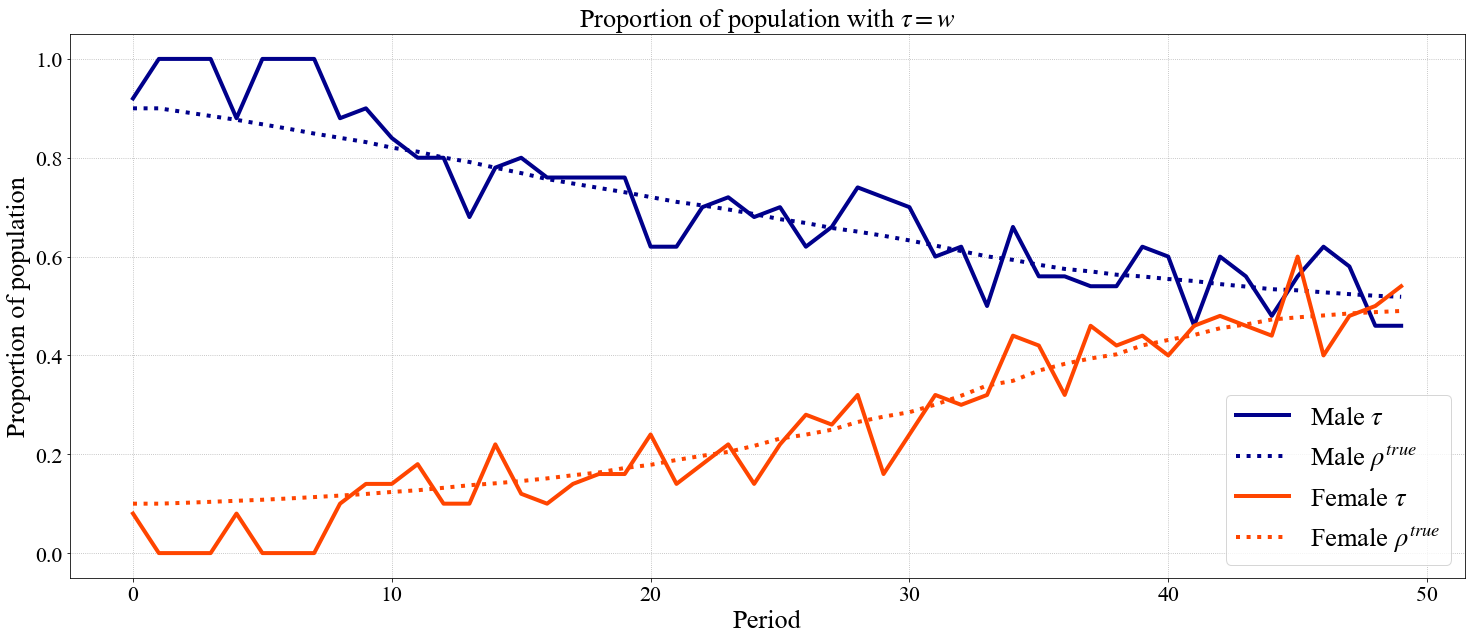

In [162]:
plot_tau_w()

### Match agents.

Here I create a new dataframe containing the payoffs that each match receives.<br><br>

#### Create a function that returns the payoff.
This function first determines whether or not a match is complementary, and then determines whether or not the individuals are concordantly or discordantly trained. Depending on these traits, the function returns a payoff value.

In [124]:
def return_payoff(match, pis=payoffs):
    
    # initialize variables
    pi1 = pis[0]
    pi2 = pis[1]
    pi3 = pis[2]
    pi4 = pis[3]
    pi5 = pis[4]
    pi6 = pis[5]
    
    # match will be a list with two elements
    training = match[0]
    aptitude = match[1]
    
    if all(educ == training[0] for educ in training): # non-complementary training
        
        if training[0] == aptitude[0] and training[1] == aptitude[1]: 
            # 2 concordantly trained partners
            payoff = pi4
        elif training[0] != aptitude[0] and training[1] != aptitude[1]:
            # 2 discordantly trained partners
            payoff = pi6
        else:
            # 1 concordant, 1 discordant
            payoff = pi5
        
    else: # complementary training
        
        if training[0] == aptitude[0] and training[1] == aptitude[1]:
            # 2 concordantly trained partners
            payoff = pi1
        elif training[0] != aptitude[0] and training[1] != aptitude[1]:
            # 2 discordantly trained partners
            payoff = pi3
        else:
            # 1 concordant, 1 discordant
            payoff = pi2
    
    return payoff

#### Match agents and determine payoffs.

Now I match agents. I match F1 with M1, F2 with M2, etc. Although this may not seem random, since aptitude distributions are random and the agents do not strategically select who they are matched with, the matches are random. This simulates "true love", a random process.<br>
The cell below matches agents and retrieves their family payoff, appending it to the list payoffs_t. payoffs_t contains all family payoffs for generation t. Each payoffs_t is appended to payoff_matrix, which will be converted into a DataFrame.

In [125]:
payoff_matrix = []

for rownum in row_indices:
    
    payoffs_t = [] # create a list containing family payoffs in time t

    # for each male id
    for id in Mcol_heads[:-1]:
        # create IDs for that male, female, and their training
        male_ID = id
        fem_ID = 'F'+id[1:]
        training_ID = 'T'+id[1:]
        
        # locate aptitudes
        male_apt = maledf.loc[:,male_ID][rownum]
        fem_apt = femdf.loc[:,fem_ID][rownum]
        
        # locate training decisions
        male_tau = maledf.loc[:,training_ID][rownum]
        fem_tau = femdf.loc[:, training_ID][rownum]
        
        # create the match matrix
        match = [[fem_tau, male_tau],[fem_apt, male_apt]]
        # find the family payoff
        fam_payoff = return_payoff(match)
        # append it to the payoff list for this period
        payoffs_t.append(fam_payoff)

    payoff_matrix.append(payoffs_t)

#### Convert to a DataFrame.

I create column headers below. Column headers will be [Match 1, Match 2, ..., Match n], depending on the IDs of the individuals within the match.<br>
The row indices will stay the same. The rows denote the time period.

In [126]:
famcol_heads = []
for id in Mcol_heads[:-1]:
    fam_id = 'Match '+id[1:]
    famcol_heads.append(fam_id)

Finally, the payoff_matrix is converted to a DataFrame. The numerical values for the payoffs are held in the DataFrame.

In [127]:
payoffdf = pd.DataFrame(payoff_matrix, columns=famcol_heads, index=row_indices)

#### Create a TRUE payoff DataFrame.
What would the payoffs be with the training decisions made with knowledge of $\rho_{true}$? Here I create a separate DataFrame.

In [128]:
true_payoff_matrix = []

for rownum in row_indices:
    
    true_payoffs_t = [] # create a list containing family payoffs in time t

    # for each male id
    for id in Mcol_heads[:-1]:
        # create IDs for that male, female, and their training with TRUE RHO
        male_ID = id
        fem_ID = 'F'+id[1:]
        training_ID = 'True T'+id[1:]
        
        # locate aptitudes
        male_apt = maledf.loc[:,male_ID][rownum]
        fem_apt = femdf.loc[:,fem_ID][rownum]
        
        # locate training decisions
        male_tau = maledf.loc[:,training_ID][rownum]
        fem_tau = femdf.loc[:, training_ID][rownum]
        
        # create the match matrix
        match = [[fem_tau, male_tau],[fem_apt, male_apt]]
        # find the family payoff
        fam_payoff = return_payoff(match)
        # append it to the payoff list for this period
        true_payoffs_t.append(fam_payoff)

    true_payoff_matrix.append(true_payoffs_t)

In [129]:
true_colheads = []
for id in Mcol_heads[:-1]:
    fam_id = 'Match '+id[1:]+' (True)'
    true_colheads.append(fam_id)
    
true_payoffdf = pd.DataFrame(true_payoff_matrix, columns=true_colheads, index=row_indices)

#### Animate a bar graph of payoffs.

Here I create a pseudo-animation of payoff frequency over time. It is a bar graph that shows with what frequency each payoff is achieved every period using $\rho_{true}$ versus $\rho_{belief}$. <br><br>

*(Note: This is a matplotlib pop-up animation that cannot be stopped until it runs its course. I have also written it so that each frame is saved to the current directory.)*

In [130]:
# %matplotlib

# freq = [0]*6
# freq_true = [0]*6
# payoff_labels = [r'$\pi_{1}$', r'$\pi_{2}$', r'$\pi_{3}$', r'$\pi_{4}$', r'$\pi_{5}$', r'$\pi_{6}$']

# # for each t
# for rownum in row_indices:
#     plt.clf()
    
#     # make a list of the payoffs that period
#     data = [pi for pi in payoffdf.iloc[rownum]]
#     # make a list of the TRUE RHO payoffs that period
#     data_true = [pi_true for pi_true in true_payoffdf.iloc[rownum]]
    
#     # count how often each payoff occurs that period
#     count1 = data.count(payoffs[0])
#     count2 = data.count(payoffs[1])
#     count3 = data.count(payoffs[2])
#     count4 = data.count(payoffs[3])
#     count5 = data.count(payoffs[4])
#     count6 = data.count(payoffs[5])
#     freq = [count1, count2, count3, count4, count5, count6]
    
#     # count how often each payoff using TRUE RHO occurs that period
#     count1_true = data_true.count(payoffs[0])
#     count2_true = data_true.count(payoffs[1])
#     count3_true = data_true.count(payoffs[2])
#     count4_true = data_true.count(payoffs[3])
#     count5_true = data_true.count(payoffs[4])
#     count6_true = data_true.count(payoffs[5])
#     freq_true = [count1_true, count2_true, count3_true, count4_true, count5_true, count6_true]


#     plt.title('t = ' + str(rownum))
#     plt.xlabel('Payoffs')
#     plt.ylabel('Occurences per period')
#     plt.ylim(0, len(data))
    
#     # create X_axis variable
#     X_axis = np.arange(len(payoff_labels))
#     # use X_axis to shift bars and plot
#     plt.bar(X_axis - 0.2, freq, 0.4, label='Payoffs using '+str(r'$\rho_{belief}$'), 
#             color='plum')
#     plt.bar(X_axis + 0.2, freq_true, 0.4, label='Payoffs using '+str(r'$\rho_{true}$'), 
#             color='indigo')
#     # set payoff_labels at the bottom
#     plt.xticks(X_axis, payoff_labels)
    
#     # create legend
#     plt.legend(loc='upper right')
    
# #     plt.bar(payoff_labels, freq)
# #     plt.bar(payoff_labels, freq_true)

#     plt.pause(0.01)
#     figname = 'bargraph'+str(rownum)+'.png'
#     plt.savefig(figname)
    
# # plt.show();

In [131]:
# # restore matplotlib settings
# %matplotlib inline

#### Show $\rho_{true}$ and $\rho_{belief}$ graph from plot_rho( ) with lines to mark where the payoffs are equal or unequal.

Incorporate neq_lines from plot_rho earlier. These lines mark the time periods where agents make suboptimal decisions. Conversely, eq_lines mark the time periods where agents make optimal decisions, but this is less interesting since agents make optimal decisions the vast majority of the time. 

In [132]:
# zeroed frequency lists
freq = [0]*6
freq_true = [0]*6

# empty payoff equality lists
not_equal = []
equal = []

# for each time period
for rownum in row_indices:
    
    # make a list of the payoffs that period
    data = [pi for pi in payoffdf.iloc[rownum]]
    # make a list of the TRUE RHO payoffs that period
    data_true = [pi_true for pi_true in true_payoffdf.iloc[rownum]]
    
    # count how often each payoff occurs that period
    count1 = data.count(payoffs[0])
    count2 = data.count(payoffs[1])
    count3 = data.count(payoffs[2])
    count4 = data.count(payoffs[3])
    count5 = data.count(payoffs[4])
    count6 = data.count(payoffs[5])
    freq = [count1, count2, count3, count4, count5, count6]
    
    # count how often each payoff using TRUE RHO occurs that period
    count1_true = data_true.count(payoffs[0])
    count2_true = data_true.count(payoffs[1])
    count3_true = data_true.count(payoffs[2])
    count4_true = data_true.count(payoffs[3])
    count5_true = data_true.count(payoffs[4])
    count6_true = data_true.count(payoffs[5])
    freq_true = [count1_true, count2_true, count3_true, count4_true, count5_true, count6_true]
    
    # rho (belief)
    rhom_belief = maledf.loc[:,'Belief of ' + str(r'$\rho$')][rownum]
    rhof_belief = femdf.loc[:,'Belief of ' + str(r'$\rho$')][rownum]
    # rho (true)
    rhom_true = maledf.loc[:,'True rho'][rownum]
    rhof_true = femdf.loc[:,'True rho'][rownum]
    
    if freq != freq_true:
        not_equal.append(rownum)
    if freq == freq_true:
        equal.append(rownum)

The periods in which agents make suboptimal decisions are:

In [133]:
not_equal

[0, 3, 5, 6, 7]

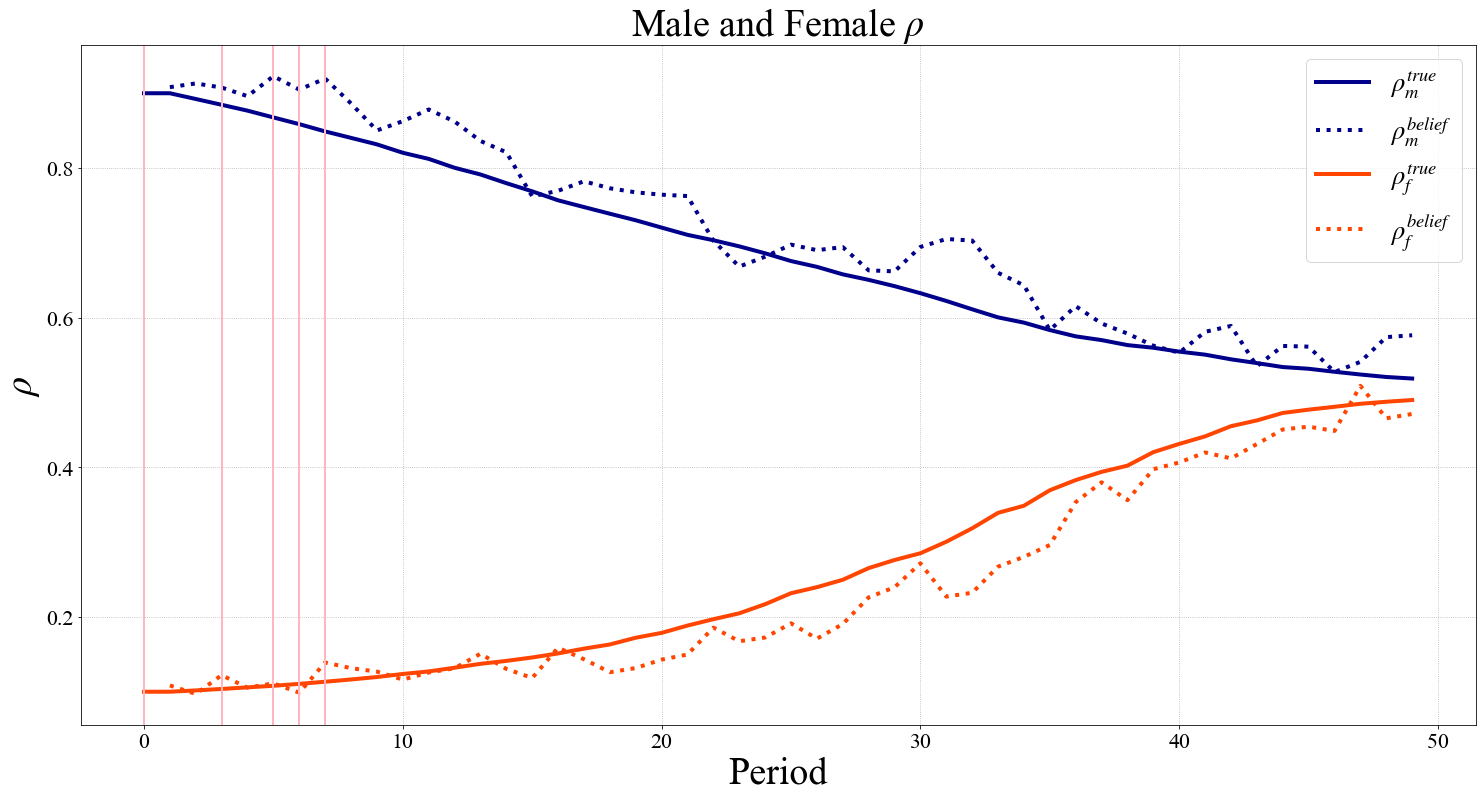

In [138]:
plot_rho(neq_lines=not_equal)

### Plot and animate the evolution.

This diagram shows the equilibria over the entire parameter space of $\rho_{m}$ and $\rho_{f}$. This section plots the true values of $\rho_{m}$ and $\rho_{f}$ (using black points) and illustrates the true equilibrium strategy in each period. This is contrasted with the believed values of $\rho_{m}$ and $\rho_{f}$, which are plotted using white points.

#### Create arrays of the true rho values.

In [139]:
true_rho_m = [rho for rho in maledf['True rho']]
true_rho_f = [rho for rho in femdf['True rho']]

# create a list with both
true_rho = [true_rho_m, true_rho_f]

#### Create arrays of the believed rho values.

In [140]:
# the beliefs used to make decisions come from the OPPOSITE gender's DataFrame.
# however, the believed value of rho_m is found in maledf
believed_rho_m = [rho for rho in maledf['Belief of ' + str(r'$\rho$')]]
believed_rho_f = [rho for rho in femdf['Belief of ' + str(r'$\rho$')]]

# create a list with both
believed_rho = [believed_rho_m, believed_rho_f]

#### Create the plot.
This function creates the .gif that shows the evolution of rho_m and rho_f over time.

In [141]:
# adjust font
tnr = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 22}
mpl.rc('font', **tnr)

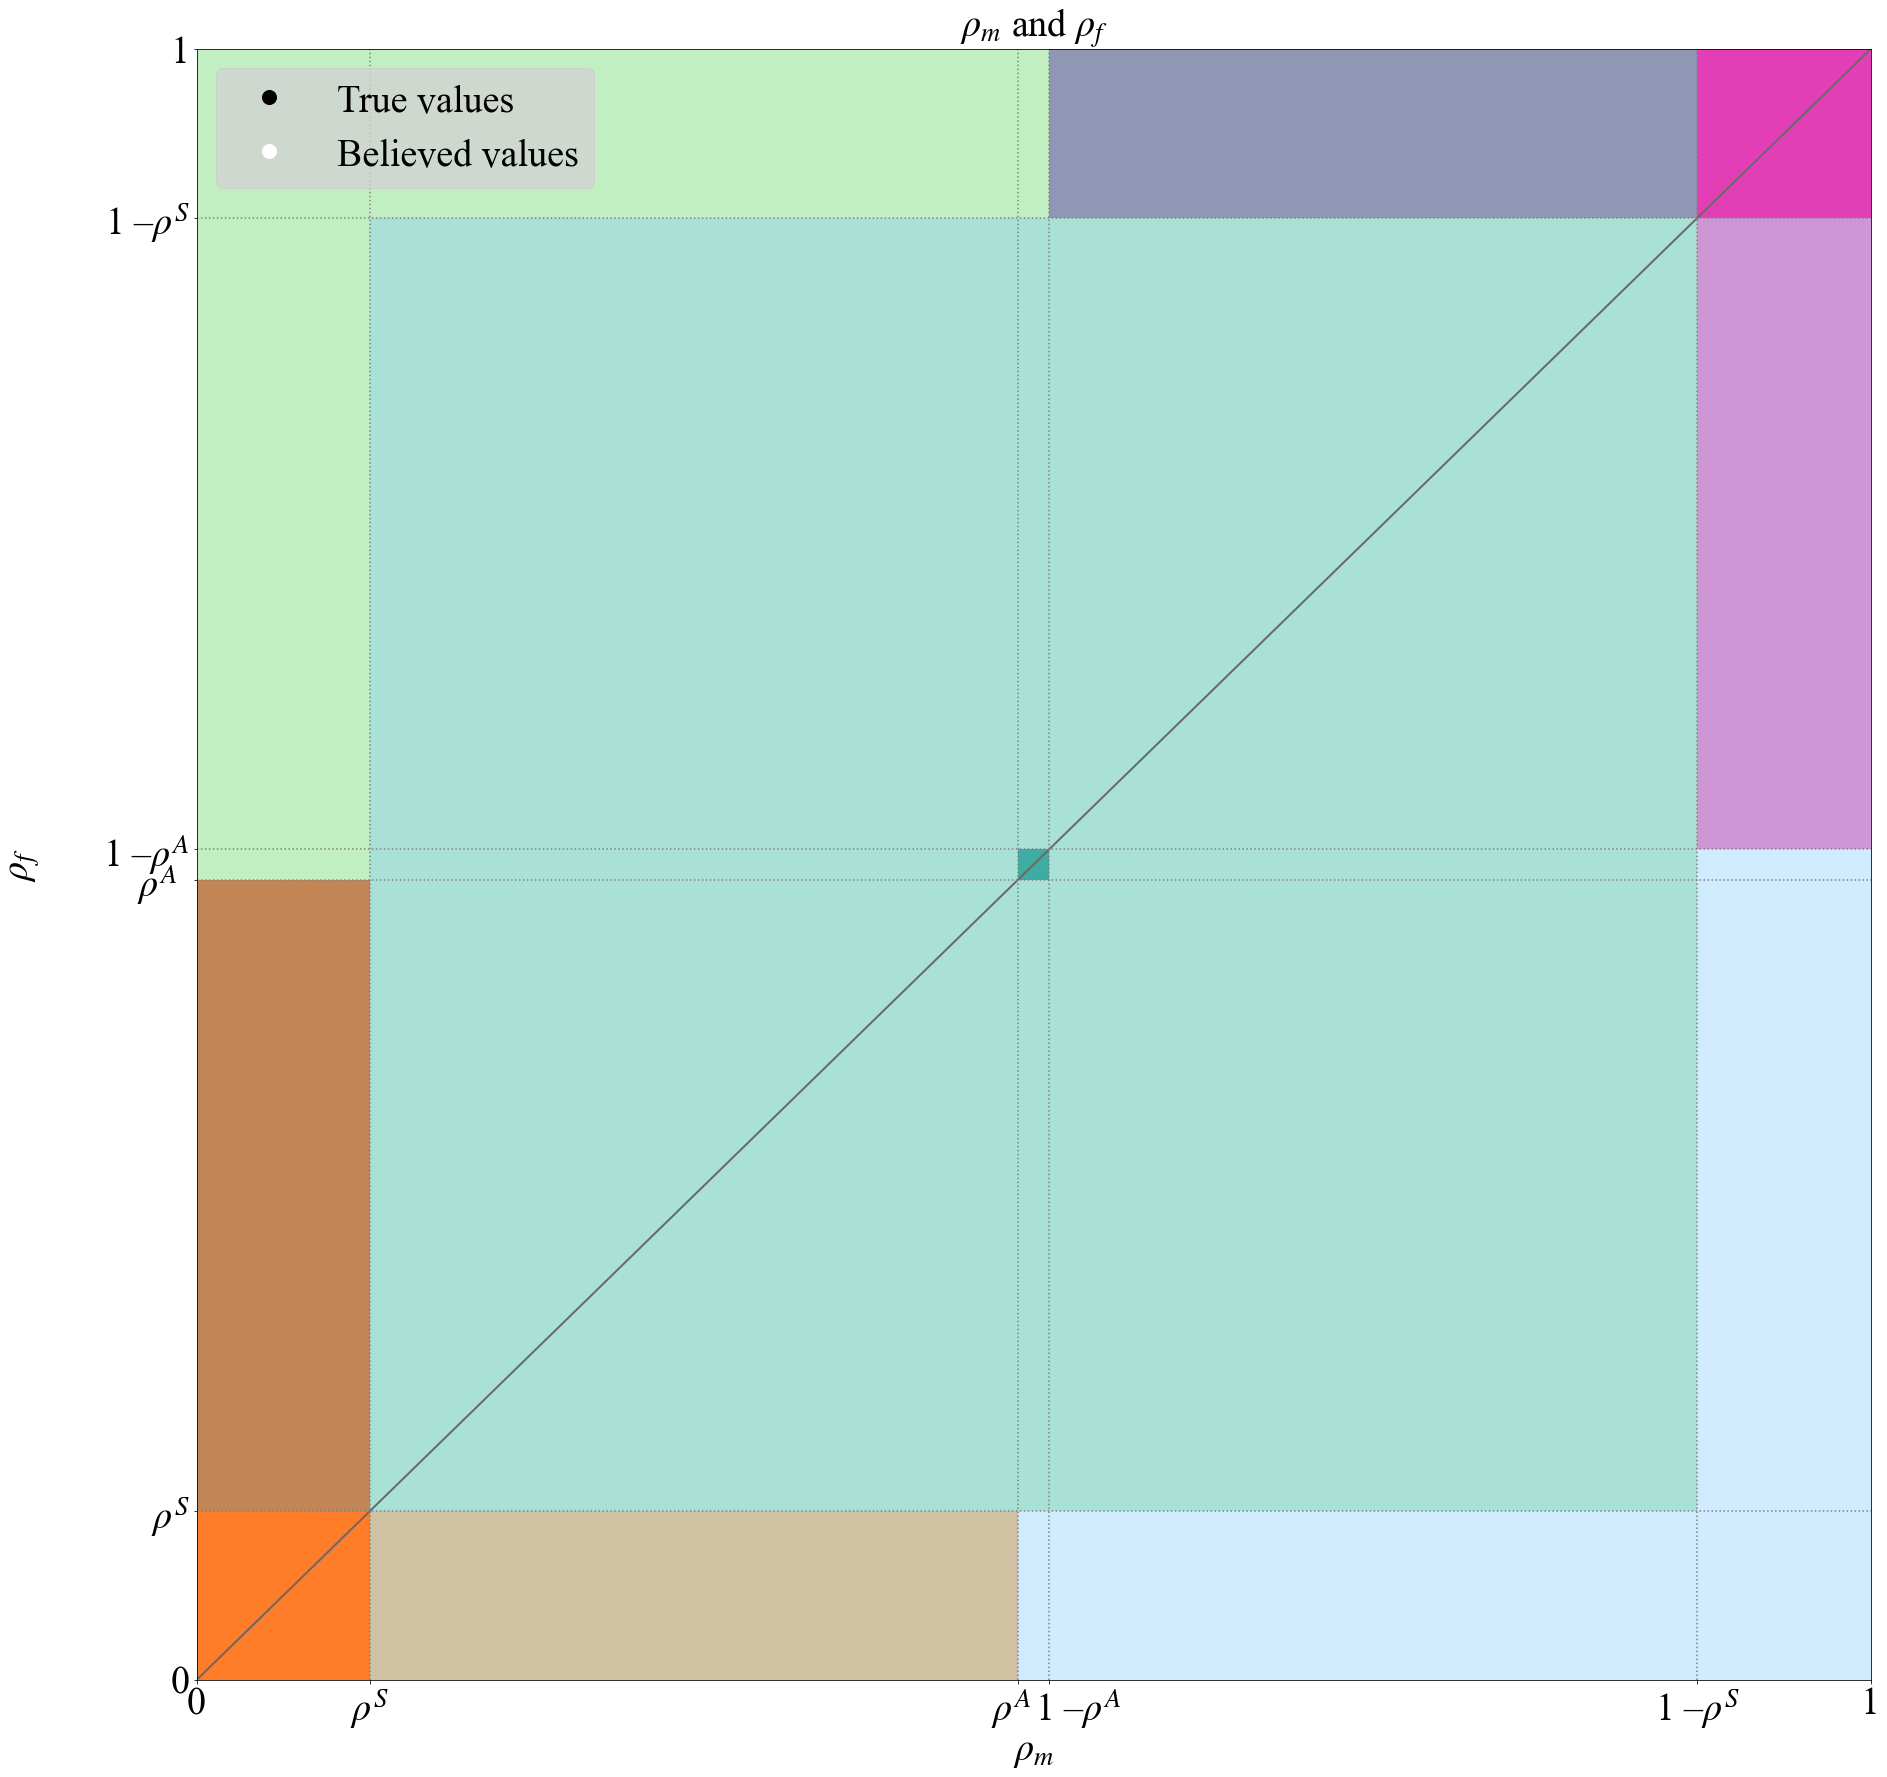

MovieWriter imagemagick unavailable; using Pillow instead.


In [148]:
fig, ax = plt.subplots(figsize=(30,30))
plt.xlabel(r'$\rho_{m}$', fontsize='xx-large')
plt.ylabel(r'$\rho_{f}$', fontsize='xx-large')
plt.title(r'$\rho_{m}$' + ' and ' + r'$\rho_{f}$', fontsize='xx-large')

# set rho_ticks at specific rho marks
rho_ticks = ['0', r'$\rho^{S}$', r'$\rho^{A}$  ', '      1 –' + str(r'$\rho^{A}$'),
             '1 –' + r'$\rho^{S}$', '1']
tick_locator = FixedLocator([0, interval_s[0], interval_a[0],
                            interval_a[1], interval_s[1], 1])

adata, bdata = [], []
xdata, ydata = [], []

truept, = plt.plot([], [], 'ko', markersize='14')
beliefpt, = plt.plot([], [], 'wo', markersize='14')
# diagonal
plt.plot([0,1], [0,1], color='dimgrey', linewidth=2)
ax.legend(['True values', 'Believed values'], facecolor='lightgrey', fontsize='xx-large')

def init(interval_a=interval_a, interval_s=interval_s, 
         ticks=rho_ticks, locations=tick_locator):
    
    # limit the axes to (0,1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # set x-axis ticks in the right places
    ax.xaxis.set_major_locator(locations)
    ax.set_xticklabels(ticks, fontsize='xx-large')
    # set y-axis ticks in the right places
    ax.yaxis.set_major_locator(locations)
    ax.set_yticklabels(ticks, fontsize='xx-large')
    
    # set region boundaries - interval_a
    for i in interval_a:
        ax.axhline(i, color='grey', linestyle='dotted')
        ax.axvline(i, color='grey', linestyle='dotted')
    # set region boundaries - interval_s
    for i in interval_s:
        ax.axhline(i, color='grey', linestyle='dotted')
        ax.axvline(i, color='grey', linestyle='dotted')

    # by aptitude
    ax.axhspan(interval_a[0], interval_a[1], interval_a[0], interval_a[1], facecolor='teal')
    # Hybrid I
    ax.axhspan(0, interval_a[0], 0, interval_s[0], facecolor='red', alpha=0.6)
    ax.axhspan(0, interval_s[0], 0, interval_a[0], facecolor='darkorange', alpha=0.6)
    # Hybrid II
    ax.axhspan(interval_s[1], 1, interval_a[1], 1, facecolor='blueviolet', alpha=0.6)
    ax.axhspan(interval_a[1], 1, interval_s[1], 1, facecolor='deeppink', alpha=0.6)
    # by sex
    ax.axhspan(interval_s[0], 1, 0, interval_s[1], facecolor='limegreen', alpha=0.3)
    ax.axhspan(0, interval_s[1], interval_s[0], 1, facecolor='lightskyblue', alpha=0.4)
    
    return truept,
    return beliefpt,


def update(frame, true_rho=true_rho, believed_rho=believed_rho):
    
    adata.append(true_rho[0][frame])
    bdata.append(true_rho[1][frame])
    truept.set_data(adata, bdata)
    
    xdata.append(believed_rho[0][frame])
    ydata.append(believed_rho[1][frame])
    beliefpt.set_data(xdata, ydata)
    
    return truept,
    return beliefpt,


gens = len(true_rho[0])

ani = FuncAnimation(fig, update, frames=gens,
                    init_func=init, blit=True)

plt.show()
ani.save('evo_plot_test.gif', writer='imagemagick')